# QFT in Qiskit



## Discrete Fourier Transform Background

It's useful to start by revisiting the DFT, since the QFT is just a DFT performed on state amplitudes with quantum gates.

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

As a reminder, the Fourier transform takes our time-domain signal and transforms it into frequency space.

In the *discrete* FT case, we run the FT using $N$ evenly-spaced samples of the actual signal. As long as the signal contains no frequency components larger than $N/2$, this sampling is **perfect** and allows complete reconstruction of the source (the [Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)).

### Simple Examples

We can use the `np.fft.fft` function from numpy to visualize this (this is just an efficient algorithm for computing the DFT). The blue lollipops are the signal samples, and the orange lollipops are the DFT'ed signal.

For example, our pure (complex) sine wave $e^{ix}$ becomes a delta function at $\omega = 1$:

<StemContainer object of 3 artists>

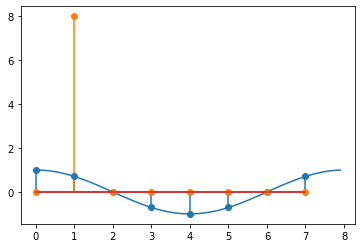

In [78]:
f = lambda x: np.exp(1j * x * np.pi / 4)

# 8 samples of the pure wave with frequency 1
x = np.arange(8)
plt.stem(f(x).real, use_line_collection=True)

# Also plot the "continuous" version
xsmooth = np.arange(0, 8, 0.1)
plt.plot(xsmooth, f(xsmooth).real)

plt.stem(np.fft.fft(f(x)).real, use_line_collection=True, linefmt='C1-', markerfmt='C1o')

If we add an $\omega = 2$ wave to our original signal, we see two deltas at the respective frequencies:

<StemContainer object of 3 artists>

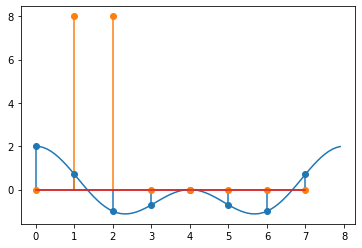

In [79]:
f = lambda x: np.exp(1j * x * np.pi / 4) + np.exp(2j * x * np.pi / 4)

# 8 samples of freq 1 + freq 2 wave
x = np.arange(8)
plt.stem(f(x).real, use_line_collection=True)

# Also plot the "continuous" version
xsmooth = np.arange(0, 8, 0.1)
plt.plot(xsmooth, f(xsmooth).real)

plt.stem(np.fft.fft(f(x)).real, use_line_collection=True, linefmt='C1-', markerfmt='C1o')

### Impulse Examples

We can take a look at the DFT of impulse signals (i.e. delta functions). As a reminder, the DFT is defined as:

$$\tilde{Y}(x) = \sum_{k=0}^{N-1} x[k] e^{-i x k \frac{2\pi}{N}}$$

where $x[k]$ is the vector of signal samples. Substituting a delta function at the kth index:

$$\tilde{Y}(x) = e^{-i x k \frac{\pi}{4}}$$

For the delta function at 0, this is the straightforward uniform frequency case:

<StemContainer object of 3 artists>

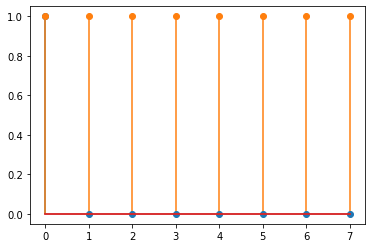

In [81]:
y = [1, 0, 0, 0, 0, 0, 0, 0]

plt.stem(np.fft.fft(y).real, use_line_collection=True, linefmt='C1-', markerfmt='C1o')

For a *displaced* delta function, this seems more complicated (imaginary part in green):

<StemContainer object of 3 artists>

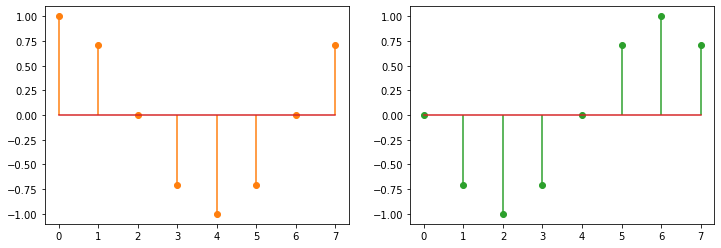

In [101]:
y = [0, 1, 0, 0, 0, 0, 0, 0]
fft = np.fft.fft(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.stem(fft.real, use_line_collection=True, linefmt='C1-', markerfmt='C1o')
ax2.stem(fft.imag, use_line_collection=True, linefmt='C2-', markerfmt='C2o')

But we can see that this is actually a set of rotating constant-magnitude frequency phasors:

<StemContainer object of 3 artists>

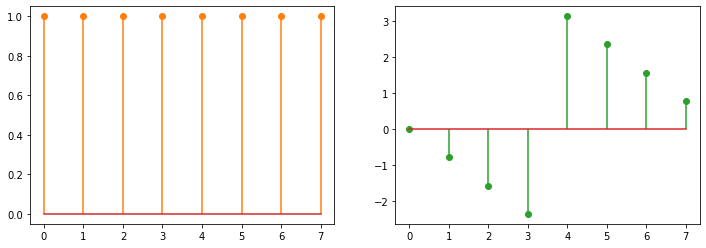

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.stem(np.abs(fft), use_line_collection=True, linefmt='C1-', markerfmt='C1o')
ax2.stem(np.angle(fft), use_line_collection=True, linefmt='C2-', markerfmt='C2o')

## Quantum Fourier Transform

Moving back to the quantum case, the QFT is the DFT applied to the amplitudes of the statevector. This takes, for example, a statevector in the position basis to the momentum basis:

$$ |p\rangle = \frac{1}{\sqrt{N}}\sum_{q=0}^{N-1}e^{\frac{2\pi}{N} i p q} |q\rangle $$

However, we take the $|q\rangle$ state in the *binary* representation, and we take the number of bins $N$ to be a power of 2, $N = 2^n$ for some integer $n$.

For example, we can represent a 4-bin QFT with 2 bits:

$$ |0\rangle \rightarrow |00\rangle \\
|1\rangle \rightarrow |01\rangle \\
|2\rangle \rightarrow |10\rangle \\
|3\rangle \rightarrow |11\rangle $$

We can use this transformation to rewrite the QFT in a *product representation* (Note that this is general — see N&C 5.1 — but we take an explicit case for clarity):

$$ \begin{aligned}
|p\rangle 
&= \frac{|00\rangle + e^{i\frac{\pi}{2} p} |01\rangle + e^{i\frac{2\pi}{2} p} |10\rangle + e^{i\frac{3\pi}{2} p } |11\rangle}{2} \\
&= \frac{\left(|0\rangle + e^{i\frac{2\pi}{2} p} |1\rangle \right) \left(|0\rangle + e^{i\frac{2\pi}{4} p} |1\rangle \right)}{2}
\end{aligned} $$

If we also write $|p\rangle$ in the binary representation as $|p_1 p_0\rangle$, then the $p$ in the exponent needs to be converted too: $p = 2p_1+ p_0$:

$$ \begin{aligned}
|p\rangle 
&= \frac{\left(|0\rangle + e^{i 2\pi \left(p_1 + \frac{p_0}{2}\right)} |1\rangle \right) \left(|0\rangle + e^{i 2\pi \left(\frac{p_1}{2} + \frac{p_0}{4}\right)} |1\rangle \right)}{2} \\
&= \frac{\left(|0\rangle + e^{i 2\pi \frac{p_0}{2}} |1\rangle \right) \left(|0\rangle + e^{i 2\pi \left(\frac{p_1}{2} + \frac{p_0}{4}\right)} |1\rangle \right)}{2}
\end{aligned} $$

where the $e^{i 2\pi p_1}$ can be removed, since $p_1$ can only be a 0 or a 1. This is a product state, so we see that each output qubit of the QFT is the $|+\rangle$ state with some additional phase rotation, depending on whether or not the respective qubits of the input qubits are $|1\rangle$.

### Binary Fractions Aside

It's useful to quickly introduce some binary notation.

As a refresher, a base-10 number like 1234 really means $1* 10^3 + 2*10^2 + 3*10^1 + 4*10^0$.

Similarly, a binary number 1011 is $1*2^3 + 0*2^2 + 1*2^1 + 1*2^0 = 11$.

----

A base-10 fraction, 0.1053 is $1 * 10^{-1} + 0*10^{-2} + 5*10^{-3} + 3*10^{-4}$.

Thus, the binary fraction 0.1011 is $1 * 2^{-1} + 0*2^{-2} + 1*2^{-3} + 1*2^{-4} = \frac{1}{2} + \frac{1}{8} + \frac{1}{16}$.

### Decomposition of QFT Product Representation into Gates 

We can use this to shorten the notation above:

$$\begin{aligned}
|p_1 p_0\rangle &= \frac{\left(|0\rangle + e^{i 2\pi \frac{p_0}{2}} |1\rangle \right) \left(|0\rangle + e^{i 2\pi \left(\frac{p_1}{2} + \frac{p_0}{4}\right)} |1\rangle \right)}{2} \\
&= \frac{\left(|0\rangle + e^{i 2\pi 0.p_0} |1\rangle \right) \left(|0\rangle + e^{i 2\pi 0.p_1 p_0} |1\rangle \right)}{2} \end{aligned}$$

and we can generalize the pattern:

$$|p_{n-1},\ldots,p_0\rangle = \frac{\left(|0\rangle + e^{i 2\pi 0.p_0} |1\rangle \right) \left(|0\rangle + e^{i 2\pi 0.p_1 p_0} |1\rangle \right) \cdots \left(|0\rangle + e^{i 2\pi 0.p_{n-1}\ldots p_1 p_0} |1\rangle \right)}{2^{n/2}}$$

Starting from the leftmost qubit in the product output, we see that applying the Hadamard gate on $|p_0\rangle$ produces the desired state up to a normalization factor, and is also in fact the 1-qubit QFT itself:

$$|0\rangle \rightarrow \frac{|0\rangle + |1\rangle}{\sqrt{2}} \equiv |+\rangle\\
|1\rangle \rightarrow \frac{|0\rangle - |1\rangle}{\sqrt{2}} \equiv |-\rangle$$

The next qubit starts with a Hadamard on $|p_1\rangle$, giving:
$$\frac{|0\rangle + e^{i 2\pi 0.p_1} |1\rangle}{\sqrt{2}}$$

and we see that we need to apply an additional $\frac{\pi}{4}$ phase rotation if $|p_0\rangle$ is $|1\rangle$. This is a *controlled-S* gate, but in general we can see that the pattern continues with phase rotations cut in half again each time.

Let's implement this two qubit case in qiskit:

### Qiskit QFT Circuit

In [140]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_bloch_multivector

Note that we have to create the $|p_1\rangle$ state first, since we need to use the original $|p_0\rangle$ state as the input to our *controlled-phase* gate before we can Hadamard it.

There's also a subtle detail: note that the "first" output qubit (i.e. the one that's simply the Hadamard of $|p_0\rangle$) is the *leftmost* qubit, so it needs to be swapped into the $|p_1\rangle$ position. In the general case, this means we need to *reverse* the order of the output qubits, and we can do this by swapping pairs of outputs. Remember that in Qiskit the convention is that the least-significant bit is on top, and readout starts from the bottom and goes up.

Our complete QFT gate, then:

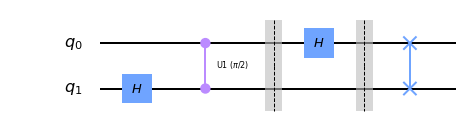

In [119]:
circ = QuantumCircuit(2)

circ.h(1)
circ.cu1(np.pi/2, 0, 1)
circ.barrier()
circ.h(0)
circ.barrier()
circ.swap(0, 1)

circ.draw(output='mpl')

And similarly, we can do the 3-qubit QFT:

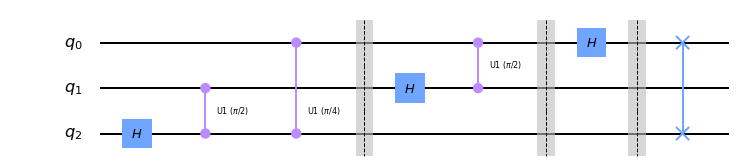

In [164]:
circ = QuantumCircuit(3)
circ.h(2)
circ.cu1(np.pi/2, 1, 2)
circ.cu1(np.pi/4, 0, 2)
circ.barrier()
circ.h(1)
circ.cu1(np.pi/2, 0, 1)
circ.barrier()
circ.h(0)
circ.barrier()
circ.swap(0, 2)

circ.draw(output='mpl')

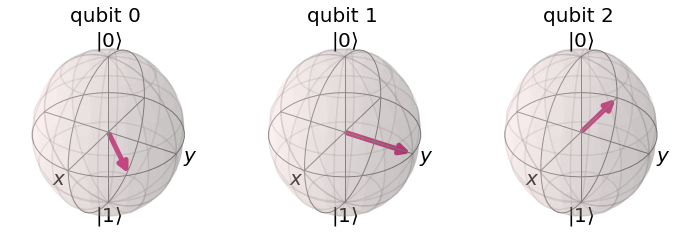

In [165]:
prepend = QuantumCircuit(3)
prepend.x(0)
circ = prepend + circ
backend = Aer.get_backend("statevector_simulator")
statevector = execute(circ, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

### Qiskit Built-In Implementation

There's an oddity here that has to do with the reversed input of the QFT. This isn't simply just a swap of the outputs, as the reversed input will change the phase of the gates. There's some discussion at the below issues but it's unclear to me what exactly is going on. Our implementation matches the Quirk example, though:

https://github.com/Qiskit/qiskit-tutorials/issues/698
https://github.com/Qiskit/qiskit-textbook/issues/34

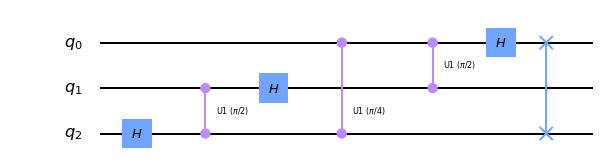

In [170]:
from qiskit.circuit.library import QFT
circ = QuantumCircuit(3)
circ.append(QFT(3), [2, 1, 0]) # Not sure why Qiskit implements this in reverse
dcirc = circ.decompose()
dcirc.draw(output='mpl')

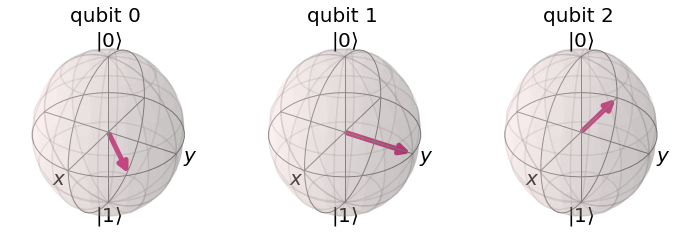

In [171]:
circ = prepend + circ
backend = Aer.get_backend("statevector_simulator")
statevector = execute(circ, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

There's also a really nice "real-time" visualization on Quirk:
[Quirk QFT](https://algassert.com/quirk#circuit={%22cols%22:[[%22Counting8%22],[%22Chance8%22],[%22%E2%80%A6%22,%22%E2%80%A6%22,%22%E2%80%A6%22,%22%E2%80%A6%22,%22%E2%80%A6%22,%22%E2%80%A6%22,%22%E2%80%A6%22,%22%E2%80%A6%22],[%22Swap%22,1,1,1,1,1,1,%22Swap%22],[1,%22Swap%22,1,1,1,1,%22Swap%22],[1,1,%22Swap%22,1,1,%22Swap%22],[1,1,1,%22Swap%22,%22Swap%22],[%22H%22],[%22Z^%C2%BD%22,%22%E2%80%A2%22],[1,%22H%22],[%22Z^%C2%BC%22,%22Z^%C2%BD%22,%22%E2%80%A2%22],[1,1,%22H%22],[%22Z^%E2%85%9B%22,%22Z^%C2%BC%22,%22Z^%C2%BD%22,%22%E2%80%A2%22],[1,1,1,%22H%22],[%22Z^%E2%85%9F%E2%82%81%E2%82%86%22,%22Z^%E2%85%9B%22,%22Z^%C2%BC%22,%22Z^%C2%BD%22,%22%E2%80%A2%22],[1,1,1,1,%22H%22],[%22Z^%E2%85%9F%E2%82%83%E2%82%82%22,%22Z^%E2%85%9F%E2%82%81%E2%82%86%22,%22Z^%E2%85%9B%22,%22Z^%C2%BC%22,%22Z^%C2%BD%22,%22%E2%80%A2%22],[1,1,1,1,1,%22H%22],[%22Z^%E2%85%9F%E2%82%86%E2%82%84%22,%22Z^%E2%85%9F%E2%82%83%E2%82%82%22,%22Z^%E2%85%9F%E2%82%81%E2%82%86%22,%22Z^%E2%85%9B%22,%22Z^%C2%BC%22,%22Z^%C2%BD%22,%22%E2%80%A2%22],[1,1,1,1,1,1,%22H%22],[%22Z^%E2%85%9F%E2%82%81%E2%82%82%E2%82%88%22,%22Z^%E2%85%9F%E2%82%86%E2%82%84%22,%22Z^%E2%85%9F%E2%82%83%E2%82%82%22,%22Z^%E2%85%9F%E2%82%81%E2%82%86%22,%22Z^%E2%85%9B%22,%22Z^%C2%BC%22,%22Z^%C2%BD%22,%22%E2%80%A2%22],[1,1,1,1,1,1,1,%22H%22]]})

## Phase Estimation